<a href="https://colab.research.google.com/github/Nancy-Shi/ICE_Manuscript/blob/main/main_code(match_beta_NN%2C_heterogeneous).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3-Layer Model with Informtion, Behavior, Disease

In [ ]:
#!pip install hypernetx

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import hypernetx as hnx

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math as math
from math import log
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker


## Part 1: Hypergraph Generation
The following steps generate a hyper graph using the XGI/HyperNetX python package,  following power-law degree distribution for predifined number of nodes n, number of hyperedges num_hyper_edges, degree exponent gamma, using a configuration model with data stored in a dictionary.

In [6]:
# Step 1: Generate Degree Sequence
def generate_degree_sequence(n, gamma, kmin):
    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(np.sqrt(n))
    #kmax = int(((gamma-1)/(gamma-2) * n )** (1/gamma))  # max degree
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n:
        degrees = degrees[:n]
    else:
        degrees = np.concatenate((degrees, np.full(n - len(degrees), kmin)))

    return degrees.tolist()

# Step 2: Generate Hyper Edge Size Sequence
def generate_hyper_edge_sizes(degrees, num_hyper_edges):
    total_degrees = sum(degrees)
    hyper_edge_sizes = []

    # Calculate the average size for each hyper edge
    avg_size = total_degrees // num_hyper_edges
    remainder = total_degrees % num_hyper_edges

    # Define the range for the random distribution
    min_size = 2  # Lower bound of the range
    max_size = int(np.sqrt(total_degrees))  # Upper bound of the range
    #max_size = len(degrees) - num_hyper_edges  # Upper bound of the range

    # Generate hyper edge sizes
    for _ in range(num_hyper_edges):
        size = random.randint(min_size, max_size)
        hyper_edge_sizes.append(size)

    return hyper_edge_sizes


# Step 3: Create Copies of Nodes
def create_node_copies(degrees):
    node_copies = []
    for i, degree in enumerate(degrees):
        for _ in range(degree):
            node_copies.append(i)
    return node_copies

# Step 4: Create Copies of Hyper Edges
def create_hyper_edge_copies(hyper_edge_sizes):
    hyper_edge_copies = []
    for i, size in enumerate(hyper_edge_sizes):
        for _ in range(size):
            hyper_edge_copies.append(i)
    return hyper_edge_copies

# Step 5: Randomly Pair Copies without Repeated Pairs
def randomly_pair_copies(node_copies, hyper_edge_copies):
    pairs = []
    paired_hyper_edges = {} # Using a dictionary to track paired hyper-edges with nodes

    for node_copy in node_copies:
        available_hyper_edges = [h for h in hyper_edge_copies if (h, node_copy) not in paired_hyper_edges]

        # If no available hyper-edges left, shuffle the paired hyper-edges and reset
        if not available_hyper_edges:
            paired_hyper_edges = {}
            available_hyper_edges = [h for h in hyper_edge_copies if (h, node_copy) not in paired_hyper_edges]

        # Randomly choose a hyper-edge that has not been paired yet with the current node
        chosen_hyper_edge = random.choice(available_hyper_edges)
        pairs.append((node_copy, chosen_hyper_edge))

        # Add to paired_hyper_edges
        paired_hyper_edges[(chosen_hyper_edge, node_copy)] = True
        hyper_edge_copies.remove(chosen_hyper_edge)

    return pairs

# Step 6: Convert Bipartite Graph to A Hypergraph Dictionary
def convert_to_hypergraph(pairs):
    hypergraph = {}
    for pair in pairs:
        node, hyper_edge = pair
        if hyper_edge in hypergraph:
            hypergraph[hyper_edge].append(node)
        else:
            hypergraph[hyper_edge] = [node]
    return hypergraph


In [7]:
def build_hypergraph(n, gamma, kmin, num_hyper_edges):
    # Step 1: Generate Degree Sequence
    degrees = generate_degree_sequence(n, gamma, kmin)
    print("Degree Sequence: ", degrees)

    # Step 2: Generate Hyper Edge Size Sequence
    hyper_edge_sizes = generate_hyper_edge_sizes(degrees, num_hyper_edges)
    print("Hyper Edge Sizes: ", hyper_edge_sizes)

    # Step 3: Create Copies of Nodes
    node_copies = create_node_copies(degrees)

    # Step 4: Create Copies of Hyper Edges
    hyper_edge_copies = create_hyper_edge_copies(hyper_edge_sizes)

    # Step 5: Randomly Pair Copies
    pairs = randomly_pair_copies(node_copies, hyper_edge_copies)

    # Step 6: Convert Bipartite Graph to Hypergraph
    hyperedge_dict = convert_to_hypergraph(pairs)

    # Print the resulting hypergraph
    print("Hypergraph Dictionary: ", hyperedge_dict)

    return degrees, hyperedge_dict

In [8]:
# Test 2
n2 = 500  # Number of nodes
gamma2 = 2.5  # Power-law exponent
kmin2 = 3  # Minimum degree
num_hyper_edges2 = 300  # Desired number of hyper edges

degrees2, hyperedge_dict2 = build_hypergraph(n2, gamma2, kmin2, num_hyper_edges2)
H2 = hnx.Hypergraph(hyperedge_dict2)

Degree Sequence:  [4, 4, 3, 3, 5, 11, 3, 6, 3, 3, 9, 20, 5, 3, 5, 3, 3, 4, 3, 18, 3, 10, 3, 8, 4, 4, 5, 3, 5, 3, 3, 3, 3, 9, 4, 4, 4, 3, 4, 5, 3, 3, 3, 11, 3, 8, 7, 3, 7, 4, 3, 7, 5, 6, 4, 3, 5, 8, 4, 3, 10, 4, 6, 9, 10, 3, 3, 3, 5, 3, 4, 6, 3, 4, 4, 5, 4, 3, 7, 3, 6, 3, 3, 4, 3, 3, 3, 3, 7, 3, 5, 4, 3, 9, 4, 5, 4, 3, 3, 4, 5, 4, 3, 9, 20, 3, 3, 16, 3, 4, 3, 8, 3, 4, 4, 3, 3, 3, 4, 6, 3, 3, 16, 14, 8, 3, 3, 3, 4, 22, 3, 3, 6, 4, 7, 7, 6, 3, 3, 3, 4, 5, 4, 3, 3, 4, 14, 3, 3, 3, 10, 3, 5, 5, 3, 3, 5, 3, 3, 5, 3, 4, 6, 3, 3, 3, 3, 3, 3, 4, 6, 3, 3, 5, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

## Part 2: Assign Behavior Status
NP represents the state of no protection, while P represents the state of with protection.

In [9]:
def assign_protection(hypergraph, fraction_protected):
    # Get the list of nodes from the hypergraph
    nodes = list(hypergraph.nodes())

    # Calculate the number of nodes to protect
    num_nodes_to_protect = int(len(nodes) * fraction_protected)

    # Randomly choose nodes to protect
    nodes_to_protect = random.sample(nodes, num_nodes_to_protect)

    # Initialize the protection status dictionary
    protection_status = {}

    # Assign protection status to each node
    for node in nodes:
        if node in nodes_to_protect:
            protection_status[node] = "P"  # Protected node
        else:
            protection_status[node] = "N"  # Non-protected node

    #print(protection_status)

    return protection_status

In [10]:
# Test:
fraction_protected = 0.1
protection_status_dict = assign_protection(H2, fraction_protected)
print(protection_status_dict)

{0: 'N', 19: 'N', 107: 'N', 112: 'N', 196: 'N', 211: 'N', 225: 'P', 340: 'N', 350: 'N', 456: 'P', 101: 'N', 234: 'N', 447: 'N', 467: 'N', 26: 'N', 64: 'N', 70: 'N', 229: 'N', 259: 'N', 292: 'N', 451: 'N', 401: 'N', 437: 'P', 1: 'N', 113: 'N', 131: 'P', 189: 'N', 244: 'N', 353: 'N', 362: 'N', 440: 'P', 10: 'N', 17: 'N', 53: 'N', 137: 'N', 146: 'P', 155: 'N', 174: 'P', 217: 'N', 228: 'N', 341: 'N', 419: 'P', 30: 'N', 138: 'N', 209: 'N', 310: 'N', 466: 'N', 68: 'N', 79: 'N', 2: 'N', 427: 'N', 7: 'N', 58: 'N', 80: 'N', 122: 'N', 216: 'N', 380: 'N', 402: 'N', 413: 'N', 470: 'N', 3: 'N', 62: 'N', 63: 'N', 88: 'N', 92: 'N', 164: 'N', 232: 'N', 288: 'N', 294: 'N', 394: 'N', 471: 'N', 21: 'N', 57: 'N', 95: 'N', 140: 'N', 168: 'N', 213: 'N', 386: 'N', 444: 'N', 60: 'N', 139: 'N', 219: 'N', 245: 'N', 342: 'N', 399: 'N', 490: 'P', 4: 'N', 9: 'P', 43: 'N', 81: 'P', 85: 'N', 103: 'N', 233: 'N', 236: 'N', 371: 'N', 75: 'N', 100: 'N', 108: 'N', 41: 'N', 45: 'N', 51: 'P', 104: 'N', 134: 'N', 194: 'N', 


## Part 3: Assign Threshold
The following steps assigns a threshold value to each node in the network. The threshold follows a uniform or normal distribution with predefined mean (mu) and standard deviation (sigma).

In [11]:
# Defines the parameters to be used
mu = 0.1
sigma = 0.05

# Function to assign thresholds to the individual nodes
def assign_thresholds(hypergraph, mu, sigma):
    NV = hypergraph.order()
    Ltre = {}

    for node in hypergraph.nodes():
          # Uniform distribution: #
          #Ltre[node] = np.random.uniform()
          # Normal distrution
          while True:
              threshold = random.gauss(mu, sigma)
              if 0 < threshold < 1:
                  break
          Ltre[node] = threshold

    return Ltre

In [12]:
Ltre2 = assign_thresholds(H2, mu, sigma)

print("Threshold List for Nodes: ", Ltre2 )

Threshold List for Nodes:  {0: 0.14271523179772308, 19: 0.10333133303317459, 107: 0.1387035120631777, 112: 0.07160129201410426, 196: 0.11409055990939022, 211: 0.09030025921846356, 225: 0.11500833546790064, 340: 0.15243134633722655, 350: 0.1921808613772633, 456: 0.1974558945977801, 101: 0.023244405210975996, 234: 0.047639029672014645, 447: 0.026907957026317306, 467: 0.08942625130019048, 26: 0.14788738829258521, 64: 0.18349494352190676, 70: 0.1448912775022182, 229: 0.12285033407370681, 259: 0.13972282147448942, 292: 0.11831968918650014, 451: 0.09136860281798656, 401: 0.14319699793641033, 437: 0.08949203556878879, 1: 0.07241382219993711, 113: 0.07690138247023104, 131: 0.07419551377743294, 189: 0.1573036665941456, 244: 0.16512801197488847, 353: 0.05666159213887412, 362: 0.08922171067544946, 440: 0.08060837211345576, 10: 0.1612904428692336, 17: 0.11861994934432357, 53: 0.1353263966228968, 137: 0.03974828399420323, 146: 0.10909118847017481, 155: 0.04568804833837751, 174: 0.03617950264943558,

# Part 4: The ICE Model (The Information Cognition Epidemics Model)
## Information Layer
The misinformation spread occurs on a hyperedge network involving group spreading. The three stages are U(unaware), G(gossip/spreader), and C(stifler/corrected).  

## Cognition Layer
In the cognitive behavioral layer, P is protected, and N is not protected. The rate of transition from state P to N, p, depends on the information layer. The rate from NP to P is 1-p. The transition rate of a node is also affected by the number of active spreader/stiflers. The bigger number of active neighbors, the faster the rate. Another way behavior may change is based on the fraction of protected neighbors.

## Epidemics Layer
In the epidemics layer, the possible disease states are S(susceptible), I(infected), and R(recovered). The illness spreading is pairwise. The disease propagation rate depends on the fraction of protected individuals $\rho_P$.



In [13]:
n = 500  # Number of nodes

# Information Layer
gamma_i = 2.5  # Power-law exponent
kmin_i = 3  # Minimum degree
num_hyper_edges_i = 450  # Desired number of hyper edges
ldeg_i, hyperedge_dict_i = build_hypergraph(n, gamma_i, kmin_i, num_hyper_edges_i)
inw = hnx.Hypergraph(hyperedge_dict_i)
ltre = assign_thresholds(inw, 0.10, 0.05)
print("Acceptance Threshold Sequence: ", ltre)

Degree Sequence:  [19, 3, 3, 15, 3, 3, 3, 8, 4, 8, 5, 3, 4, 4, 5, 4, 8, 3, 3, 3, 3, 3, 5, 11, 8, 3, 5, 6, 3, 3, 3, 3, 9, 3, 3, 5, 3, 3, 3, 5, 3, 3, 5, 4, 3, 4, 4, 3, 5, 4, 22, 3, 3, 3, 3, 9, 3, 3, 13, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 3, 6, 3, 11, 5, 3, 7, 3, 5, 6, 3, 5, 4, 9, 4, 3, 3, 3, 5, 3, 4, 13, 8, 3, 12, 4, 7, 4, 4, 3, 3, 9, 4, 6, 6, 4, 4, 3, 13, 4, 3, 4, 3, 3, 7, 6, 18, 7, 4, 4, 11, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 4, 6, 4, 4, 3, 4, 9, 3, 3, 6, 5, 3, 18, 3, 4, 3, 3, 3, 3, 3, 4, 3, 22, 3, 3, 3, 3, 12, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

In [16]:
# Cognition Layer
gamma_c = 3.0  # Power-law exponent
kmin_c = 3  # Minimum degree
ldeg_c = generate_degree_sequence(n, gamma_c, kmin_c)
print("Behavior Degree Sequence: ", ldeg_c)
cnw = nx.configuration_model(ldeg_c)
frac_prot = 0.05
lprot = assign_protection(cnw, frac_prot)

Behavior Degree Sequence:  [3, 3, 7, 4, 9, 3, 5, 4, 3, 3, 3, 3, 3, 3, 3, 4, 6, 3, 3, 3, 4, 5, 3, 4, 3, 3, 3, 5, 5, 3, 3, 3, 3, 3, 6, 3, 4, 4, 3, 6, 4, 3, 4, 5, 3, 3, 3, 7, 4, 3, 3, 3, 3, 3, 3, 3, 7, 4, 3, 4, 3, 3, 3, 12, 5, 3, 5, 3, 7, 3, 3, 3, 4, 3, 3, 3, 3, 5, 3, 5, 3, 3, 4, 3, 3, 3, 3, 3, 5, 3, 4, 7, 4, 3, 4, 3, 5, 8, 4, 3, 3, 3, 5, 3, 4, 8, 19, 5, 3, 3, 3, 5, 3, 4, 4, 3, 5, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

In [61]:
# Epidemic Layer
gamma_e = 5.0 #gamma_e = 4.75   #gamma_e = 4.0
kmin_e = 3
ldeg_e = generate_degree_sequence(n, gamma_e, kmin_e)
print("Degree Sequence: ", ldeg_e)
enw = nx.configuration_model(ldeg_e)
k = ((gamma_e-1)/(gamma_e-2))*(kmin_e) #<k>
k2 =((gamma_e-1)/(gamma_e-3))*((kmin_e)**2) #<k^2>
division_factor = (k2-k)/k # division factor to compute beta_max(<k^2>-<k>)/<k>
print(["<k>: ", k, "<k^2>: ", k2,"(<k^2>-<k>)/<k>: ",  division_factor])

Degree Sequence:  [4, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 6, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [63]:
def ICE_model(inw, ldeg_i, ltre, cnw, ldeg_c, lprot, enw, ldeg_e, lam, alp, omega, sigma, zeta_1, zeta_2, zeta_3, zeta_4, beta_PP, beta_NP, beta_PN, beta_NN, mu, n_sample):
  """
  Input:
      inw - information hyperedge network
      ltre - list of thresholds for informaiton spread
      ldeg_i - degree sequence of information layer

      cnw - cognitive network
      lprot - list of protection status
      ldeg_c - degree sequence of cognition layer

      enw - epidemic pairwise network
      ldeg_e - degree sequence of epidemic layer

      lambda - information spreading rate
      alp - informaiton stifling rate
      omega - information interest renewal rate
      sigma - correction rate

      zeta_1 - removing protection rate based on information
      zeta_2 - adopting protection rate based on information
      zeta_3 - removing protection rate based on neighborhood behavior
      zeta_4 - adopting protection rate based on neighborhood behavior

      beta_PP - disease transmission rate between protected S and protected I
      beta_NP - disease transmission rate between not protected S and protected I
      beta_PN - disease transmission rate between protected S and not protected I
      beta_NN - disease transmission rate between not protected S and not protected I

      mu - disease recovery rate

      n_sample - number of samples
  """

  t_max = 1000      # Set maximum time
  kmax_i = max (ldeg_i)     # Get maximum hyperedge degree in information layer
  kmax_c = max (ldeg_c)     # Get maximum hyperedge degree in cognition layer
  kmax_e = max (ldeg_e)     # Get maximum degree in epidemic layer
  N = inw.order()  # Get the network size

  #rho_A = []   # Keep track of fraction of stifler in information layer
  #rho_P = []   # Keep track of fraction of protected in cognition layer
  rho_R = []   # Keep track of fraction of recovered in epidemic layer

  for i_samp in range(1, n_sample + 1):
      t = 0                 # Initialize time, number of corrected, number of recovered
      N_corrected = 0
      N_recovered = 0
      N_stifler = 0

      info_states = {j: "U" for j in inw.nodes()}   # Initialize information and disease states
      disease_states = {k: "S" for k in enw.nodes()}

      lprot = assign_protection(cnw, frac_prot)
      protected = list(filter(lambda node: lprot[node] == "P", lprot))
      N_protected = len(protected)
      not_protected = list(filter(lambda node: lprot[node] == "N", lprot))

      gossip = []     # Create lists to store gossip and corrected individuals in information layer
      corrected = []
      stifler = []

      N_gossip = 0
      N_e_i = 0

      infected = []     # Create lists to store infected and recovered individuals in epidemic layer
      recovered = []

      #time_record= [0]
      #gossip_count = [0]
      #protected_count = [N_protected]
      #prevalence_count = [0]
      #recovered_count = [0]

      N_infected = 0
      N_e_e = 0
      for _ in range(10):
          ill_node_0 = np.random.choice([node for node, state in disease_states.items() if state == "S" and node in enw.nodes()])
          disease_states[ill_node_0] = "I"
          infected.append(ill_node_0)
          N_infected += 1
          N_e_e += enw.degree(ill_node_0)

      beta_max = max(beta_PP,beta_NP,beta_PN,beta_NN) # Chose the largest infection rate (I known that it is beta_NN, but keep it general)

      while t < 150 and N_infected > 0:   # We stop when there is no infection
        total_rate = lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected) + zeta_3 * N_protected + zeta_4 * (N-N_protected) + omega * N_stifler + sigma * N_gossip
        tau = -np.log(np.random.uniform(1e-6, 1)) / total_rate
        t += tau

        if t >= t_max:
                break

      # Determine which event occurs
        event = np.random.uniform()
        p1 = (lam * N_e_i) / total_rate     # rumor spreading
        p2 = (lam * N_e_i + alp * N_e_i) / total_rate  # rumor stifling (by meeting stifling neighbor threshold)
        p3 = (lam * N_e_i + 2 * alp * N_e_i) / total_rate  # rumor stifling (by meeting gossip neighbor threshold)

        p4 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e) / total_rate  # disease propagation
        p5 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected) / total_rate  # disease recovery

        p6 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_1 * N_protected) / total_rate # change to not adopting protection by information
        p7 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected) ) / total_rate # change to adopting protection by information
        p8 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected)  + zeta_3 * N_protected) / total_rate # change to not adopting protection by neighborhood behavior
        p9 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected) + zeta_3 * N_protected + zeta_4 * (N-N_protected))/total_rate # change to adopting protection by neighborhood behavior
        p10 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected) + zeta_3 * N_protected + zeta_4 * (N-N_protected) + omega * N_stifler)/total_rate # rumor interest renewal
        # >p10 correction of rummor


        # Determine if accept selected individual based on degree distribution
        q_deg_i = np.random.uniform()
        q_deg_c = np.random.uniform()
        q_deg_e = np.random.uniform()

        # Case 1: Rumor spreading
        if event < p1:
                response='F'
                while len(gossip)>0 and response =='F':
                  gossip_node = np.random.choice(gossip) #chose an infected node proportional to the degree
                  draw_rn = np.random.uniform()
                  if draw_rn < inw.degree(gossip_node)/kmax_i:
                     response='T'

                edges_containing_gossip = [edge for edge in inw.edges() if gossip_node in inw[edge]]
                if edges_containing_gossip:
                        rumor_hyper_edge = np.random.choice(edges_containing_gossip)
                        neighbors = inw[rumor_hyper_edge]
                        for neighbor in neighbors:
                            if info_states[neighbor] == "U":
                                count_gossip_neighbors = sum(1 for node in inw.neighbors(neighbor) if info_states[node] == "G")
                                if count_gossip_neighbors / len(inw.neighbors(neighbor)) >= ltre[neighbor]:
                                    info_states[neighbor] = "G"  # uninformed neighbor becomes gossip spreader
                                    gossip.append(neighbor)
                                    N_gossip += 1
                                    N_e_i += inw.degree(neighbor)
                                    #time_record.append(t)
                                    #gossip_count.append(N_gossip)
                                    #protected_count.append(N_protected)
                                    #prevalence_count.append(N_infected)
                                    #recovered_count.append(N_recovered)

        # Case 2: Rumor stifling (by meeting stifling neighbor threshold)
        elif event < p2:
                    response='F'
                    while len(gossip)>0 and response =='F':
                      stifler_node = np.random.choice(gossip) #chose an infected node proportional to the degree
                      draw_rn = np.random.uniform()
                      if draw_rn < inw.degree(stifler_node)/kmax_i:
                         response='T'

                    stifler_hyper_edge = np.random.choice(list(inw.edges()))
                    neighbors = inw[stifler_hyper_edge]
                    count_stifler_neighbors = sum(1 for node in inw.neighbors(stifler_node) if info_states[node] == "C")
                    if count_stifler_neighbors > 0:
                            info_states[stifler_node] = "A" #"C"
                            N_gossip -= 1
                            gossip.remove(stifler_node)
                            stifler.append(stifler_node) #corrected.append(stifler_node)
                            N_stifler += 1 #N_corrected += 1
                            N_e_i -= inw.degree(stifler_node)
                            #time_record.append(t)
                            #gossip_count.append(N_gossip)
                            #protected_count.append(N_protected)
                            #prevalence_count.append(N_infected)
                            #recovered_count.append(N_recovered)

        # Case 3: Rumor stifling (by meeting gossip neighbor threshold)
        elif event < p3:
                    response='F'
                    while len(gossip)>0 and response =='F':
                      stifler_node = np.random.choice(gossip) #chose an infected node proportional to the degree
                      draw_rn = np.random.uniform()
                      if draw_rn < inw.degree(stifler_node)/kmax_i:
                         response='T'

                    stifler_hyper_edge = np.random.choice(list(inw.edges()))
                    neighbors = inw[stifler_hyper_edge]
                    count_gossip_neighbors = sum(1 for node in inw.neighbors(stifler_node) if info_states[node] == "G")
                    if count_gossip_neighbors > 0:
                            info_states[stifler_node] = "A" #"C"
                            N_gossip -= 1
                            gossip.remove(stifler_node)
                            stifler.append(stifler_node) #corrected.append(stifler_node)
                            N_stifler += 1 #N_corrected += 1
                            N_e_i -= inw.degree(stifler_node)
                            #time_record.append(t)
                            #gossip_count.append(N_gossip)
                            #protected_count.append(N_protected)
                            #prevalence_count.append(N_infected)
                            #recovered_count.append(N_recovered)

        # Case 4: Disease propagation
        elif event < p4:
            # code based on the new pseudo code
            response='F'
            while len(infected)>0 and response =='F':  #draw node until degree distribution is reached and while the infected list is not empty
              infected_node = np.random.choice(infected) #choose an infected node proportional to the degree
              draw_rn = np.random.uniform()
              if draw_rn < enw.degree(infected_node)/kmax_e: # kmax_e is the global max degree
                 response='T'

            neighbors = list(enw.neighbors(infected_node)) #get the list of neighbors of the infected node
            target_node = np.random.choice(neighbors) #choose a neighbor at random
            # beta_NN > beta_PN > beta_NP > beta_PP
            if disease_states[target_node] == "S":
                if lprot[target_node] == "P" and lprot[infected_node] == "P":
                   beta_correct = beta_PP
                elif lprot[target_node] == "N" and lprot[infected_node] == "P":
                   beta_correct = beta_NP
                elif lprot[target_node] == "P" and lprot[infected_node] == "N":
                   beta_correct = beta_PN
                else:
                   beta_correct = beta_NN

                draw_rn = np.random.uniform()
                if draw_rn < beta_correct/beta_max:
                   disease_states[target_node] = "I"
                   infected.append(target_node)
                   N_infected += 1
                   N_e_e += enw.degree(target_node)
                   #time_record.append(t)
                   #gossip_count.append(N_gossip)
                   #protected_count.append(N_protected)
                   #prevalence_count.append(N_infected)
                   #recovered_count.append(N_recovered)

                   ## Start gossip after epidemic have started
                   if N_gossip == 0:
                      uninformed = [node for node, state in info_states.items() if state == "U" and node in inw.nodes()]
                      if len(uninformed) > 0:
                        rumor_node_0 = np.random.choice(uninformed)
                        info_states[rumor_node_0] = "G"
                        gossip.append(rumor_node_0)
                        N_gossip += 1
                        N_e_i += inw.degree(rumor_node_0)
                        #time_record.append(t)
                        #gossip_count.append(N_gossip)
                        #protected_count.append(N_protected)
                        #prevalence_count.append(N_infected)
                        #recovered_count.append(N_recovered)

        # Case 5: Disease recovery
        elif event < p5:
                  recovered_node = np.random.choice(infected)
                  disease_states[recovered_node] = "R"
                  infected.remove(recovered_node)
                  recovered.append(recovered_node)
                  N_infected -= 1
                  N_recovered += 1
                  N_e_e -= enw.degree(recovered_node)
                  #time_record.append(t)
                  #gossip_count.append(N_gossip)
                  #protected_count.append(N_protected)
                  #prevalence_count.append(N_infected)
                  #recovered_count.append(N_recovered)

        # Case 6: # Change to not adopting protection based on information layer
        # n_G is the total spreader neighbors on the information layer,
        # while k_info is the total neighbor count on the information layer
        elif event < p6:
            if len(protected) > 0:
              node_to_not_protect = np.random.choice(protected)
              n_G = sum(1 for node in filter(lambda x: info_states[x] == "G", inw.neighbors(node_to_not_protect)))
              k_info = len(list(inw.neighbors(node_to_not_protect)))
              frac_inf = N_infected/N
              b = 3
              if np.random.uniform() < (n_G / k_info) * (1-np.tanh(b*(frac_inf))):
                    lprot[node_to_not_protect] = "N"
                    protected.remove(node_to_not_protect)
                    not_protected.append(node_to_not_protect)
                    N_protected -= 1
                    #time_record.append(t)
                    #gossip_count.append(N_gossip)
                    #protected_count.append(N_protected)
                    #prevalence_count.append(N_infected)
                    #recovered_count.append(N_recovered)

        # Case 7: Change to adopting protection based on information layer
        elif event < p7:
            if len(not_protected) > 0:
                node_to_protect = np.random.choice(not_protected)
                n_G = sum(1 for node in filter(lambda x: info_states[x] == "G", inw.neighbors(node_to_protect)))
                k_info = len(list(inw.neighbors(node_to_protect)))
                frac_inf = N_infected/N
                b = 3
                if np.random.uniform() < (1 - n_G / k_info) * np.tanh(b*(frac_inf)):
                        lprot[node_to_protect] = "P"
                        not_protected.remove(node_to_protect)
                        protected.append(node_to_protect)
                        N_protected += 1
                        #time_record.append(t)
                        #gossip_count.append(N_gossip)
                        #protected_count.append(N_protected)
                        #prevalence_count.append(N_infected)
                        #recovered_count.append(N_recovered)


        # Case 8: # Change to not adopting protection based on neighborhood behavior in cognition layer
        # n_P is the total protected neighbors on the cognition layer,
        # while k_cog is the total neighbor count on the cognition layer
        elif event < p8:
            if len(protected) > 0:
                node_to_not_protect = np.random.choice(protected)
                n_P = sum(1 for node in filter(lambda x: lprot[x] == "P", cnw.neighbors(node_to_not_protect)))
                k_cog = len(list(cnw.neighbors(node_to_not_protect)))
                if np.random.uniform() < 1 - n_P / k_cog:
                        lprot[node_to_not_protect] = "N"
                        protected.remove(node_to_not_protect)
                        not_protected.append(node_to_not_protect)
                        N_protected -= 1
                        #time_record.append(t)
                        #gossip_count.append(N_gossip)
                        #protected_count.append(N_protected)
                        #prevalence_count.append(N_infected)
                        #recovered_count.append(N_recovered)


        # Case 9: # Change to adopting protection based on neighborhood behavior in cognition layer
        elif event < p9:
            if len(not_protected) > 0:
                node_to_protect = np.random.choice(not_protected)
                n_P = sum(1 for node in filter(lambda x: lprot[x] == "P", cnw.neighbors(node_to_protect)))
                k_cog = len(list(cnw.neighbors(node_to_protect)))
                if np.random.uniform() < n_P / k_cog:
                        lprot[node_to_protect] = "P"
                        not_protected.remove(node_to_protect)
                        protected.append(node_to_protect)
                        N_protected += 1
                        #time_record.append(t)
                        #gossip_count.append(N_gossip)
                        #protected_count.append(N_protected)
                        #prevalence_count.append(N_infected)
                        #recovered_count.append(N_recovered)

        # Case 10: Rumor interest renewal
        elif event < p10:
            if len(stifler) > 0:
                  stifler_node = np.random.choice(stifler)
                  info_states[stifler_node] = "U"
                  stifler.remove(stifler_node)
                  N_stifler -= 1

        # Case 11: Correction of rumor
        else:
            if len(gossip)>0:
                node = np.random.choice(gossip) #chose an infected node proportional to the degree
                info_states[node] = "C"
                N_gossip -= 1
                gossip.remove(node)
                corrected.append(node)
                N_corrected += 1
                N_e_i -= inw.degree(node)
                #time_record.append(t)
                #gossip_count.append(N_gossip)
                #protected_count.append(N_protected)
                #prevalence_count.append(N_infected)
                #recovered_count.append(N_recovered)

      if N_infected == 0:
        #stifler_frac = N_stifler / N
        #protected_frac = N_protected / N
        recovered_frac = N_recovered / N
        #rho_A.append(stifler_frac)
        #rho_P.append(protected_frac)
        rho_R.append(recovered_frac)

  #avg_rho_A = sum(rho_A) / len(rho_A)
  #avg_rho_P = sum(rho_P) / len(rho_P)
  avg_rho_R = sum(rho_R) / len(rho_R)

  #return avg_rho_C, avg_rho_P, avg_rho_R
  return avg_rho_R

In [65]:
lam = 1/3 # gossip spreading rate
alp = 1/3 # gossip stifling rate
omega = 1/5 # gossip renewal rate
sigma = 0 # correction rate of misinformation

zeta_1 = 0.2 #go to not protect by information
zeta_3 = 0 #go to not protect by neighborhood behavior

mu = 0.2
R0 = 4.0 #4.0 (assume a COVID19-like disease for the reproduction number) 2.0 # reproduction number
beta_NN = R0 * mu / division_factor
beta_PN = beta_NN * 0.2
beta_NP = beta_NN * 0.1
beta_PP = beta_NN * 0.0
n_sample = 50

zeta_2_values = np.arange(0.0, 0.55, 0.05)
zeta_4_values = np.arange(0.0, 0.55, 0.05)

# Initialize the result array
results_rho_R = np.zeros((len(zeta_2_values), len(zeta_4_values)))

# Iterate over values
for i, zeta_2 in enumerate(zeta_2_values):
    for j, zeta_4 in enumerate(zeta_4_values):
        avg_rho_R = ICE_model(inw, ldeg_i, ltre, cnw, ldeg_c, lprot, enw, ldeg_e, lam, alp, omega, sigma, zeta_1, zeta_2, zeta_3, zeta_4, beta_PP, beta_NP, beta_PN, beta_NN, mu, n_sample)
        results_rho_R[i, j] = avg_rho_R
        print(f"Zeta_2: {zeta_2}, Zeta_4: {zeta_4}, Attack Rate: {avg_rho_R}")

# Save result
df3 = pd.DataFrame(results_rho_R)
df3.to_csv('/content/drive/My Drive/Information_Behavior_Disease_Networks/heat_map_results/Attack_rate_match_beta.csv')

Zeta_2: 0.0, Zeta_4: 0.0, Attack Rate: 0.39596000000000003
Zeta_2: 0.0, Zeta_4: 0.05, Attack Rate: 0.3098
Zeta_2: 0.0, Zeta_4: 0.1, Attack Rate: 0.24004000000000006
Zeta_2: 0.0, Zeta_4: 0.15000000000000002, Attack Rate: 0.21892
Zeta_2: 0.0, Zeta_4: 0.2, Attack Rate: 0.18539999999999993
Zeta_2: 0.0, Zeta_4: 0.25, Attack Rate: 0.15692000000000006
Zeta_2: 0.0, Zeta_4: 0.30000000000000004, Attack Rate: 0.13963999999999996
Zeta_2: 0.0, Zeta_4: 0.35000000000000003, Attack Rate: 0.12648
Zeta_2: 0.0, Zeta_4: 0.4, Attack Rate: 0.12811999999999998
Zeta_2: 0.0, Zeta_4: 0.45, Attack Rate: 0.11499999999999998
Zeta_2: 0.0, Zeta_4: 0.5, Attack Rate: 0.10651999999999998
Zeta_2: 0.05, Zeta_4: 0.0, Attack Rate: 0.2730400000000001
Zeta_2: 0.05, Zeta_4: 0.05, Attack Rate: 0.22264000000000003
Zeta_2: 0.05, Zeta_4: 0.1, Attack Rate: 0.18608000000000005
Zeta_2: 0.05, Zeta_4: 0.15000000000000002, Attack Rate: 0.16980000000000006
Zeta_2: 0.05, Zeta_4: 0.2, Attack Rate: 0.13967999999999997
Zeta_2: 0.05, Zeta_4:

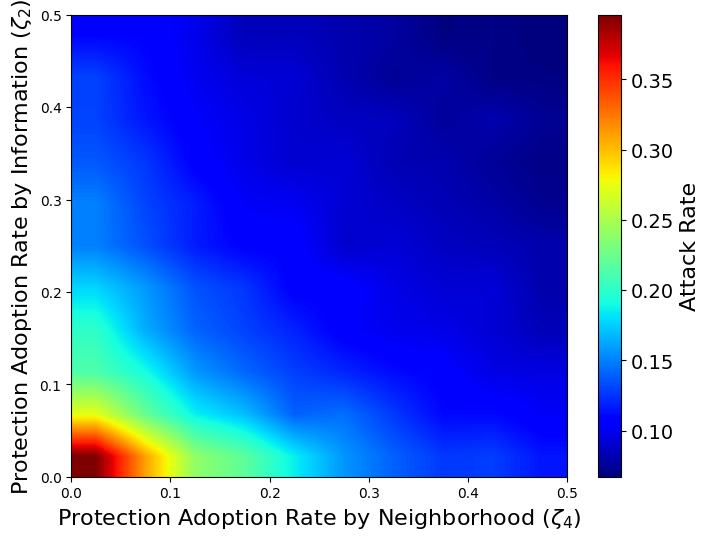

In [3]:
df = pd.read_csv('/content/drive/My Drive/Information_Behavior_Disease_Networks/heat_map_results/Attack_rate_match_beta.csv')
results_rho_R = df.to_numpy()

zeta_2_values = np.arange(0.0, 0.55, 0.05)
zeta_4_values = np.arange(0.0, 0.55, 0.05)

# Create a heatmap
fig, ax = plt.subplots(figsize=(8, 6))

# Add smoothing by interpolating the image
im = ax.imshow(results_rho_R[:, 1:11], cmap='jet', aspect='auto', origin='lower',
               extent=[min(zeta_4_values), max(zeta_4_values), min(zeta_2_values), max(zeta_2_values)],
               interpolation='bilinear')

# Setting labels, colorbar
ax.set_xlabel('Protection Adoption Rate by Neighborhood ($\\zeta_4$)', fontsize=16)
ax.set_ylabel('Protection Adoption Rate by Information ($\\zeta_2$)', fontsize=16)
cbar = plt.colorbar(im)
cbar.set_label('Attack Rate', fontsize=16)
cbar.ax.tick_params(labelsize=14)
#plt.colorbar(im, label='Attack Rate', ax=ax)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

# Display the plot
plt.savefig('/content/drive/My Drive/Information_Behavior_Disease_Networks/heat_map_results/Attack_rate_match_beta.pdf')
#plt.show()

In [ ]:
def ICE_model_record_layer(inw, ldeg_i, ltre, cnw, ldeg_c, lprot, enw, ldeg_e, lam, alp, omega, sigma, zeta_1, zeta_2, zeta_3, zeta_4, beta_PP, beta_NP, beta_PN, beta_NN, mu, n_sample):

  t_max = 1000      # Set maximum time
  kmax_i = max (ldeg_i)     # Get maximum hyperedge degree in information layer
  kmax_c = max (ldeg_c)     # Get maximum hyperedge degree in cognition layer
  kmax_e = max (ldeg_e)     # Get maximum degree in epidemic layer
  N = inw.order()  # Get the network size

  rho_A = []   # Keep track of fraction of stifler in information layer
  rho_P = []   # Keep track of fraction of protected in cognition layer
  rho_R = []   # Keep track of fraction of recovered in epidemic layer

  for i_samp in range(1, n_sample + 1):
      t = 0                 # Initialize time, number of corrected, number of recovered
      N_corrected = 0
      N_recovered = 0
      N_stifler = 0

      info_states = {j: "U" for j in inw.nodes()}   # Initialize information and disease states
      disease_states = {k: "S" for k in enw.nodes()}

      lprot = assign_protection(cnw, frac_prot)
      protected = list(filter(lambda node: lprot[node] == "P", lprot))
      N_protected = len(protected)
      not_protected = list(filter(lambda node: lprot[node] == "N", lprot))

      gossip = []     # Create lists to store gossip and corrected individuals in information layer
      corrected = []
      stifler = []

      N_gossip = 0
      N_e_i = 0

      infected = []     # Create lists to store infected and recovered individuals in epidemic layer
      recovered = []

      time_record= [0]
      #gossip_count = [0]
      #protected_count = [N_protected]
      #prevalence_count = [0]
      recovered_count = [0]

      N_infected = 0
      N_e_e = 0
      for _ in range(10):
          ill_node_0 = np.random.choice([node for node, state in disease_states.items() if state == "S" and node in enw.nodes()])
          disease_states[ill_node_0] = "I"
          infected.append(ill_node_0)
          N_infected += 1
          N_e_e += enw.degree(ill_node_0)

      beta_max = max(beta_PP,beta_NP,beta_PN,beta_NN) # Chose the largest infection rate (I known that it is beta_NN, but keep it general)

      while t < 150 and N_infected > 0:   # We stop when there is no infection
        total_rate = lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected) + zeta_3 * N_protected + zeta_4 * (N-N_protected) + omega * N_stifler + sigma * N_gossip
        tau = -np.log(np.random.uniform(1e-6, 1)) / total_rate
        t += tau

        if t >= t_max:
                break

      # Determine which event occurs
        event = np.random.uniform()
        p1 = (lam * N_e_i) / total_rate     # rumor spreading
        p2 = (lam * N_e_i + alp * N_e_i) / total_rate  # rumor stifling (by meeting stifling neighbor threshold)
        p3 = (lam * N_e_i + 2 * alp * N_e_i) / total_rate  # rumor stifling (by meeting gossip neighbor threshold)

        p4 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e) / total_rate  # disease propagation
        p5 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected) / total_rate  # disease recovery

        p6 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_1 * N_protected) / total_rate # change to not adopting protection by information
        p7 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected) ) / total_rate # change to adopting protection by information
        p8 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected)  + zeta_3 * N_protected) / total_rate # change to not adopting protection by neighborhood behavior
        p9 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected) + zeta_3 * N_protected + zeta_4 * (N-N_protected))/total_rate # change to adopting protection by neighborhood behavior
        p10 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected) + zeta_3 * N_protected + zeta_4 * (N-N_protected) + omega * N_stifler)/total_rate # rumor interest renewal
        # >p10 correction of rummor


        # Determine if accept selected individual based on degree distribution
        q_deg_i = np.random.uniform()
        q_deg_c = np.random.uniform()
        q_deg_e = np.random.uniform()

        # Case 1: Rumor spreading
        if event < p1:
                response='F'
                while len(gossip)>0 and response =='F':
                  gossip_node = np.random.choice(gossip) #chose an infected node proportional to the degree
                  draw_rn = np.random.uniform()
                  if draw_rn < inw.degree(gossip_node)/kmax_i:
                     response='T'

                edges_containing_gossip = [edge for edge in inw.edges() if gossip_node in inw[edge]]
                if edges_containing_gossip:
                        rumor_hyper_edge = np.random.choice(edges_containing_gossip)
                        neighbors = inw[rumor_hyper_edge]
                        for neighbor in neighbors:
                            if info_states[neighbor] == "U":
                                count_gossip_neighbors = sum(1 for node in inw.neighbors(neighbor) if info_states[node] == "G")
                                if count_gossip_neighbors / len(inw.neighbors(neighbor)) >= ltre[neighbor]:
                                    info_states[neighbor] = "G"  # uninformed neighbor becomes gossip spreader
                                    gossip.append(neighbor)
                                    N_gossip += 1
                                    N_e_i += inw.degree(neighbor)
                                    #time_record.append(t)
                                    #gossip_count.append(N_gossip)
                                    #protected_count.append(N_protected)
                                    #prevalence_count.append(N_infected)
                                    #recovered_count.append(N_recovered)

        # Case 2: Rumor stifling (by meeting stifling neighbor threshold)
        elif event < p2:
                    response='F'
                    while len(gossip)>0 and response =='F':
                      stifler_node = np.random.choice(gossip) #chose an infected node proportional to the degree
                      draw_rn = np.random.uniform()
                      if draw_rn < inw.degree(stifler_node)/kmax_i:
                         response='T'

                    stifler_hyper_edge = np.random.choice(list(inw.edges()))
                    neighbors = inw[stifler_hyper_edge]
                    count_stifler_neighbors = sum(1 for node in inw.neighbors(stifler_node) if info_states[node] == "C")
                    if count_stifler_neighbors > 0:
                            info_states[stifler_node] = "A" #"C"
                            N_gossip -= 1
                            gossip.remove(stifler_node)
                            stifler.append(stifler_node) #corrected.append(stifler_node)
                            N_stifler += 1 #N_corrected += 1
                            N_e_i -= inw.degree(stifler_node)
                            #time_record.append(t)
                            #gossip_count.append(N_gossip)
                            #protected_count.append(N_protected)
                            #prevalence_count.append(N_infected)
                            #recovered_count.append(N_recovered)

        # Case 3: Rumor stifling (by meeting gossip neighbor threshold)
        elif event < p3:
                    response='F'
                    while len(gossip)>0 and response =='F':
                      stifler_node = np.random.choice(gossip) #chose an infected node proportional to the degree
                      draw_rn = np.random.uniform()
                      if draw_rn < inw.degree(stifler_node)/kmax_i:
                         response='T'

                    stifler_hyper_edge = np.random.choice(list(inw.edges()))
                    neighbors = inw[stifler_hyper_edge]
                    count_gossip_neighbors = sum(1 for node in inw.neighbors(stifler_node) if info_states[node] == "G")
                    if count_gossip_neighbors > 0:
                            info_states[stifler_node] = "A" #"C"
                            N_gossip -= 1
                            gossip.remove(stifler_node)
                            stifler.append(stifler_node) #corrected.append(stifler_node)
                            N_stifler += 1 #N_corrected += 1
                            N_e_i -= inw.degree(stifler_node)
                            #time_record.append(t)
                            #gossip_count.append(N_gossip)
                            #protected_count.append(N_protected)
                            #prevalence_count.append(N_infected)
                            #recovered_count.append(N_recovered)

        # Case 4: Disease propagation
        elif event < p4:
            # code based on the new pseudo code
            response='F'
            while len(infected)>0 and response =='F':  #draw node until degree distribution is reached and while the infected list is not empty
              infected_node = np.random.choice(infected) #choose an infected node proportional to the degree
              draw_rn = np.random.uniform()
              if draw_rn < enw.degree(infected_node)/kmax_e: # kmax_e is the global max degree
                 response='T'

            neighbors = list(enw.neighbors(infected_node)) #get the list of neighbors of the infected node
            target_node = np.random.choice(neighbors) #choose a neighbor at random
            # beta_NN > beta_PN > beta_NP > beta_PP
            if disease_states[target_node] == "S":
                if lprot[target_node] == "P" and lprot[infected_node] == "P":
                   beta_correct = beta_PP
                elif lprot[target_node] == "N" and lprot[infected_node] == "P":
                   beta_correct = beta_NP
                elif lprot[target_node] == "P" and lprot[infected_node] == "N":
                   beta_correct = beta_PN
                else:
                   beta_correct = beta_NN

                draw_rn = np.random.uniform()
                if draw_rn < beta_correct/beta_max:
                   disease_states[target_node] = "I"
                   infected.append(target_node)
                   N_infected += 1
                   N_e_e += enw.degree(target_node)
                   #time_record.append(t)
                   #gossip_count.append(N_gossip)
                   #protected_count.append(N_protected)
                   #prevalence_count.append(N_infected)
                   #recovered_count.append(N_recovered)

                   ## Start gossip after epidemic have started
                   if N_gossip == 0:
                      uninformed = [node for node, state in info_states.items() if state == "U" and node in inw.nodes()]
                      if len(uninformed) > 0:
                        rumor_node_0 = np.random.choice(uninformed)
                        info_states[rumor_node_0] = "G"
                        gossip.append(rumor_node_0)
                        N_gossip += 1
                        N_e_i += inw.degree(rumor_node_0)
                        #time_record.append(t)
                        #gossip_count.append(N_gossip)
                        #protected_count.append(N_protected)
                        #prevalence_count.append(N_infected)
                        #recovered_count.append(N_recovered)

        # Case 5: Disease recovery
        elif event < p5:
                  recovered_node = np.random.choice(infected)
                  disease_states[recovered_node] = "R"
                  infected.remove(recovered_node)
                  recovered.append(recovered_node)
                  N_infected -= 1
                  N_recovered += 1
                  N_e_e -= enw.degree(recovered_node)
                  time_record.append(t)
                  #gossip_count.append(N_gossip)
                  #protected_count.append(N_protected)
                  #prevalence_count.append(N_infected)
                  recovered_count.append(N_recovered)

        # Case 6: # Change to not adopting protection based on information layer
        # n_G is the total spreader neighbors on the information layer,
        # while k_info is the total neighbor count on the information layer
        elif event < p6:
            if len(protected) > 0:
              node_to_not_protect = np.random.choice(protected)
              n_G = sum(1 for node in filter(lambda x: info_states[x] == "G", inw.neighbors(node_to_not_protect)))
              k_info = len(list(inw.neighbors(node_to_not_protect)))
              frac_inf = N_infected/N
              b = 3
              if np.random.uniform() < (n_G / k_info) * (1-np.tanh(b*(frac_inf))):
                    lprot[node_to_not_protect] = "N"
                    protected.remove(node_to_not_protect)
                    not_protected.append(node_to_not_protect)
                    N_protected -= 1
                    #time_record.append(t)
                    #gossip_count.append(N_gossip)
                    #protected_count.append(N_protected)
                    #prevalence_count.append(N_infected)
                    #recovered_count.append(N_recovered)

        # Case 7: Change to adopting protection based on information layer
        elif event < p7:
            if len(not_protected) > 0:
                node_to_protect = np.random.choice(not_protected)
                n_G = sum(1 for node in filter(lambda x: info_states[x] == "G", inw.neighbors(node_to_protect)))
                k_info = len(list(inw.neighbors(node_to_protect)))
                frac_inf = N_infected/N
                b = 3
                if np.random.uniform() < (1 - n_G / k_info) * np.tanh(b*(frac_inf)):
                        lprot[node_to_protect] = "P"
                        not_protected.remove(node_to_protect)
                        protected.append(node_to_protect)
                        N_protected += 1
                        #time_record.append(t)
                        #gossip_count.append(N_gossip)
                        #protected_count.append(N_protected)
                        #prevalence_count.append(N_infected)
                        #recovered_count.append(N_recovered)


        # Case 8: # Change to not adopting protection based on neighborhood behavior in cognition layer
        # n_P is the total protected neighbors on the cognition layer,
        # while k_cog is the total neighbor count on the cognition layer
        elif event < p8:
            if len(protected) > 0:
                node_to_not_protect = np.random.choice(protected)
                n_P = sum(1 for node in filter(lambda x: lprot[x] == "P", cnw.neighbors(node_to_not_protect)))
                k_cog = len(list(cnw.neighbors(node_to_not_protect)))
                if np.random.uniform() < 1 - n_P / k_cog:
                        lprot[node_to_not_protect] = "N"
                        protected.remove(node_to_not_protect)
                        not_protected.append(node_to_not_protect)
                        N_protected -= 1
                        #time_record.append(t)
                        #gossip_count.append(N_gossip)
                        #protected_count.append(N_protected)
                        #prevalence_count.append(N_infected)
                        #recovered_count.append(N_recovered)


        # Case 9: # Change to adopting protection based on neighborhood behavior in cognition layer
        elif event < p9:
            if len(not_protected) > 0:
                node_to_protect = np.random.choice(not_protected)
                n_P = sum(1 for node in filter(lambda x: lprot[x] == "P", cnw.neighbors(node_to_protect)))
                k_cog = len(list(cnw.neighbors(node_to_protect)))
                if np.random.uniform() < n_P / k_cog:
                        lprot[node_to_protect] = "P"
                        not_protected.remove(node_to_protect)
                        protected.append(node_to_protect)
                        N_protected += 1
                        #time_record.append(t)
                        #gossip_count.append(N_gossip)
                        #protected_count.append(N_protected)
                        #prevalence_count.append(N_infected)
                        #recovered_count.append(N_recovered)

        # Case 10: Rumor interest renewal
        elif event < p10:
            if len(stifler) > 0:
                  stifler_node = np.random.choice(stifler)
                  info_states[stifler_node] = "U"
                  stifler.remove(stifler_node)
                  N_stifler -= 1

        # Case 11: Correction of rumor
        else:
            if len(gossip)>0:
                correction_node = np.random.choice(gossip) #chose an infected node proportional to the degree
                info_states[correction_node] = "C"
                N_gossip -= 1
                gossip.remove(correction_node)
                corrected.append(correction_node)
                N_corrected += 1
                N_e_i -= inw.degree(correction_node)
                #time_record.append(t)
                #gossip_count.append(N_gossip)
                #protected_count.append(N_protected)
                #prevalence_count.append(N_infected)
                #recovered_count.append(N_recovered)

  return time_record, recovered_count